# Project Introduction

This project is an exploratory analysis on the SAT and how schools in New York performed on it. The SAT has been a controversial topic and has left many to wonder whether or not it is a reliable indicator of student success in High School, college, and beyond. Some believe the test is racially biased, while others believe it is economically biased, some say that it is gender biased. This analysis explores those relationships.

## Project workflow
- Read in [New York schools](https://data.cityofnewyork.us/browse?category=Education) data.
- Read in survey data
- Join tables on the 'DBN' column. 
- Clean the data
- Feature Engineering
- Analysis
- Conlusion


# Read in the data

In [28]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [29]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [30]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [31]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [32]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [33]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [34]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [35]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [36]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [37]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

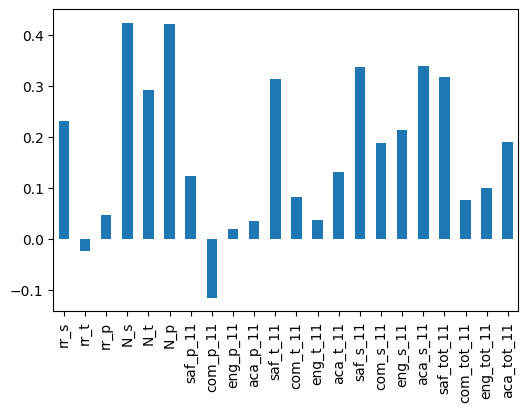

In [38]:
# Import Matplotlib
import matplotlib.pyplot as plt

# Setting up matplotlib to work in Jupyter
%matplotlib inline

# Plot the results of the survey results and their correlation with sat_score

combined.corr()["sat_score"][survey_fields].plot.bar()

# Looking at the Data Dictionary closer

To further interpret the results I believe it's necessary to list the meanings of each of the variables plotted before interpreting them. Data Dictionary:

- `rr_s`: student response rate
- `rr_t`: teacher response rate
- `rr_p`: parent response rate
- `N_s`: number of student respondents
- `N_t`: number of teacher respondents
- `N_p`: number of parent respondents
- `nr_s`: number of eligible students
- `nr_t`: number of eligible teachers
- `nr_p`: number of eligibile parents 
- `saf_p_11`: safety and respect score based on parent responses
- `com_p_11`: communication score based on parent responses
- `eng_p_11`: engagement score based on parent responses
- `aca_p_11`: academic expecatations score based on parent responses
- `saf_t_11`: safety and respect score based on teacher responses. 
- `com_t_11`: communication score based on teacher responses
- `eng_t_11`: engagement score based on teacher responses
- `aca_t_11`: academic expectations based on teacher responses
- `saf_s_11`: safety and respect score based on student responses
- `com_s_11`: communication score based on student responses
- `eng_s_11`: engagement score based on student responses
- `aca_s_11`: academic expectations scored based on student responses
- `saf_tot_11`: safety and respect total score
- `com_tot_11`: communication total score
- `eng_tot_11`: engagement total score
- `aca_tot_11`: academic expectations total score


## Observations
- I'm surprised at the negative correlation between the teacher response rate and `sat_score`.
- Again, it seems the number of teacher respondents doesn't have as much weight as the student and parent respondents in terms of correlation the `sat_score`.
- The strongest correlations tend to do with the number of students and parents who responded and the safety and respect columns. 
- Perhaps students feeling safe and respected by their teachers contributed to a higher sat_score. 
- Another interesting correlation is the weight of perception of academic standards. It seems to be more important towards the sat_score based on student perceptions.

# Exploring safety correlation to `sat_score`

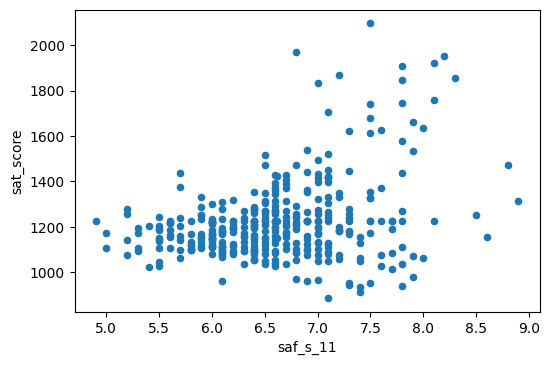

In [39]:
# Creating a scatter plot to look at the safety vs. sat score
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

## Observations
- There looks to be a correlation between SAT scores and student perceptions of safety. The correlation isn't overly strong.
- Additionally, there seems to be a few schools who have extremely high SAT scores and safety scores. 
- There are also a few schools with low SAT scores and low safety scores. 
- In the main cluster in the middle, schools with safety score between 6.5-7.0 are highly unlikely to achieve SAT scores above 1500. 

# Having a look at safety by Borough

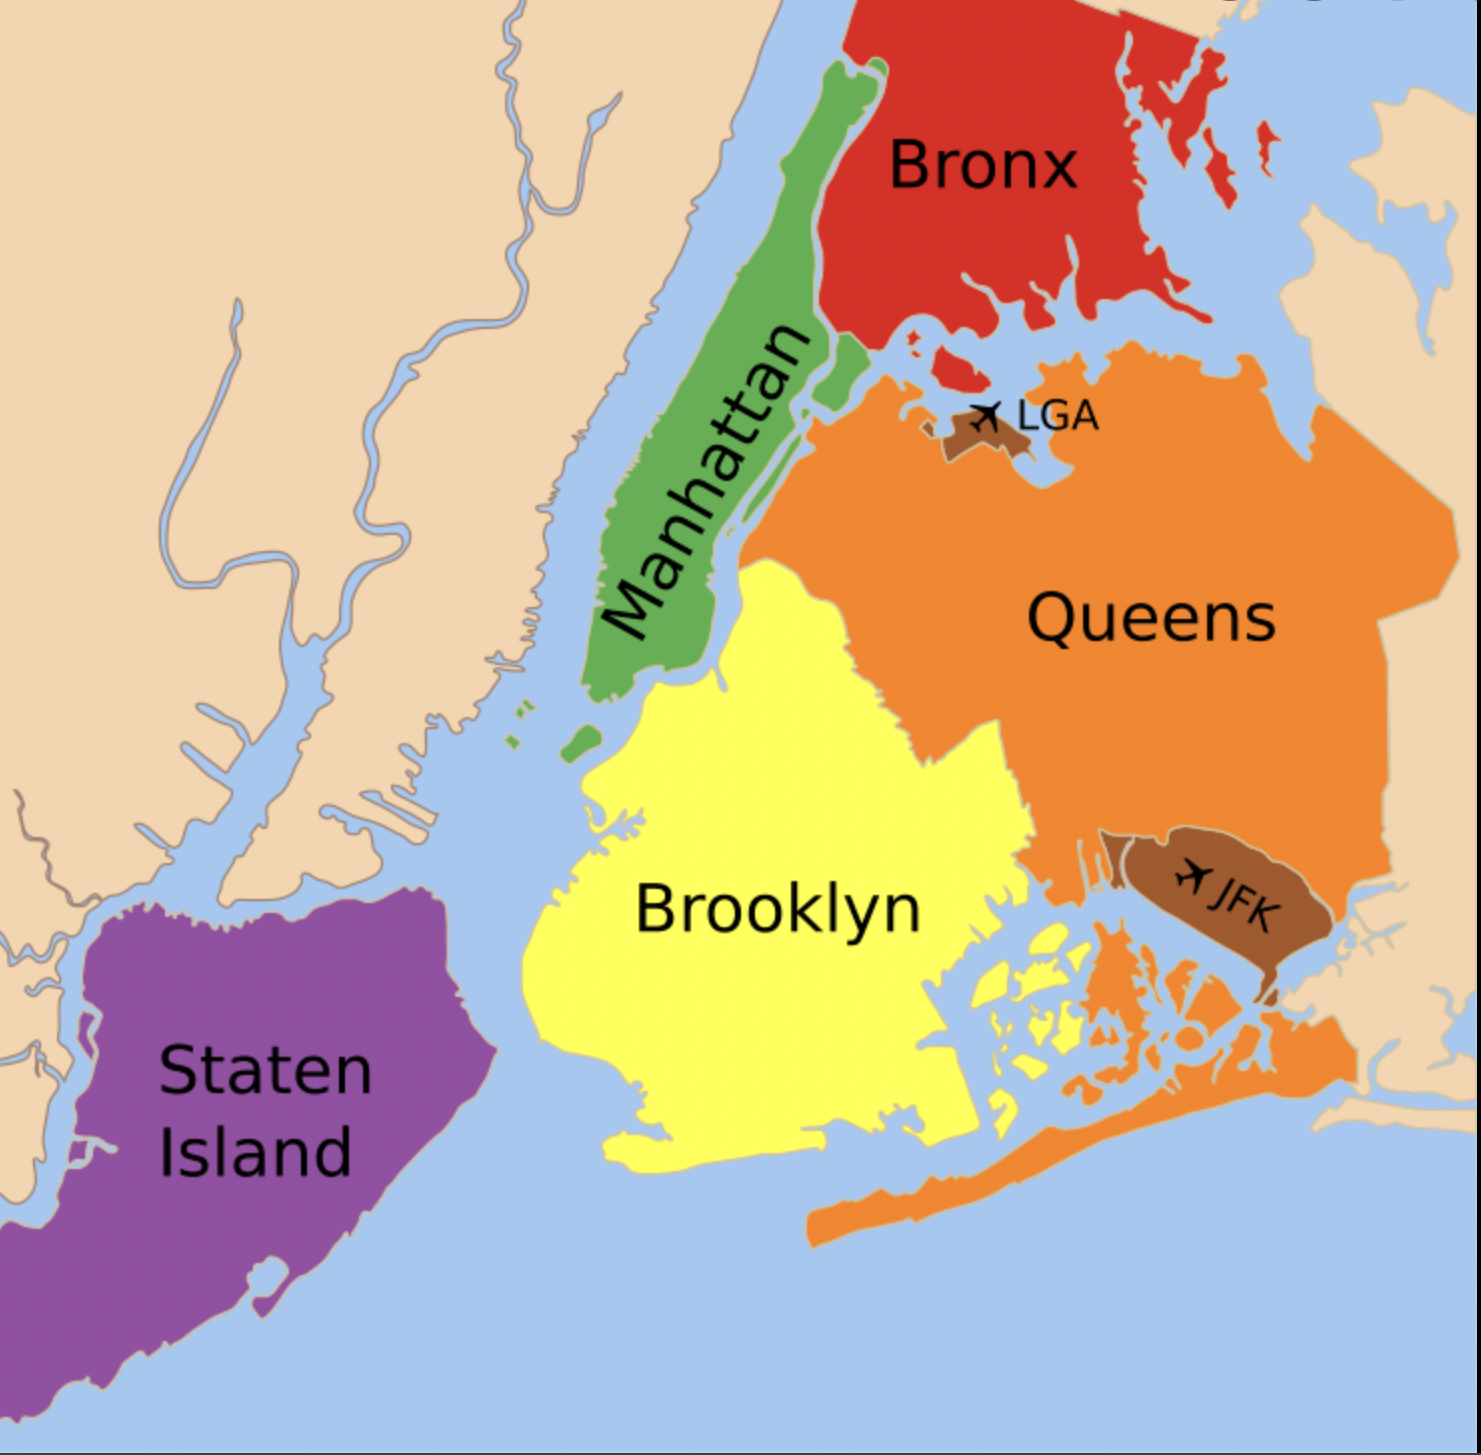
image from [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:5_Boroughs_Labels_New_York_City_Map.svg)

What we are going to do next is have alook at the safety scores by borough. The information is to granualar to explore school by school, so we're going to group by borough and compare the safety scores as they pertain to `sat_scores`. 

In [44]:
# Group by borough and compute the average safety score for each

boro = combined.groupby("boro").agg(np.mean)["saf_s_11"]

# print the results
print(boro)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


## Observations
- It looks like Manhattan and Queens have higher safety scores. Brooklyn has the lowest score with the Bronx and Staten Island rounding out the middle of the scores. 

The next part of our analysis is going to hone in the potential racial biases of the SAT. We are going to plot out the correlations between various demograpics and `sat_scores`. 

# Exploring Racial Differences and their effects on the SAT

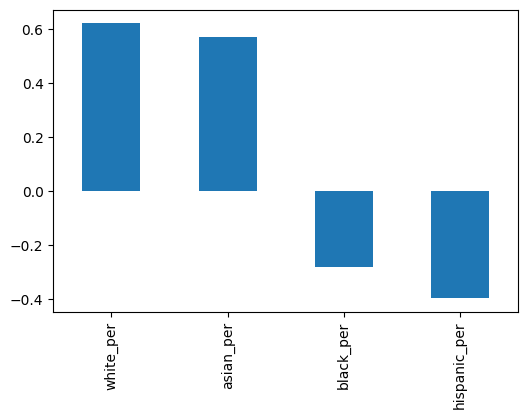

In [45]:
# Bar plot
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()
plt.show()

## Observations
- It looks like white and asian students tend to score better on the SAT based on the high positive correlations between them and `sat_score`. On the opposite end students who are black or hispanic correlate negatively with `sat_score`. This could be down to a variety of things:
    * A lack of school funding in certain areas and the percentage of the students there being predominantly black or hispanic. 
    * The safety levels of schools in certain areas and the schools likely having higher black or hispanic populations. 
    
To further extend our analysis, I'm going to have a look at schools with low SAT scores and high values for hispanic students. 

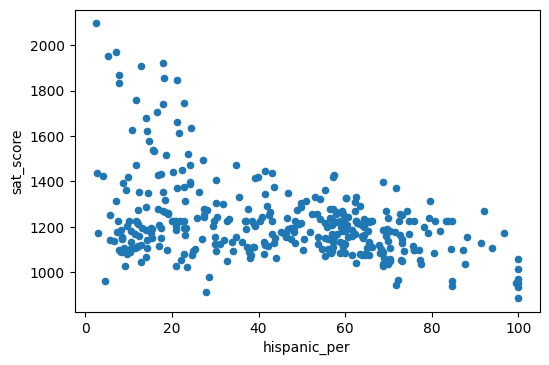

In [49]:
# Scatterplot exploring hispanic students and low sat scores
combined.plot.scatter(x = "hispanic_per", y = "sat_score")
plt.show()

## Observations
- It looks like like there is a significant relationship with schools that have higher hispanic populations and their SAT performance. 
- This was indicated earlier, but there is a linear relationship between the two. 

Next, I'm going to research schools that have hispanic populations greater than 95%. To do that I'll have to filter my dataframe down to schools matching this criteria. 


In [51]:
# Filter for high hispanic population schools

hispanic_95 = combined[combined["hispanic_per"] >= 95]["SCHOOL NAME"]
print(hispanic_95)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## Observations
- After researching these schools it seems that the schools tend to be designated for recent immigrants. There are a lot of English languaged learners and thus, they probably struggle on the SAT as a result.

Next, I'm going to look at schools on the opposite side where they have low hispanic populations and higher SAT scores (over 1800). I'll need to filter the combined dataframe based on this information again. 

In [53]:
# Filter the dataframe for low hispanic populations and high SAT scores

low_his_high_sat = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]
print(low_his_high_sat)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## Observations
- It looks like these schools are science and technology schools. They are likely to have extra funding and only admit students who pass entrance exams which neans they are picking highly talented students already. This still doesn't explain what's going on with hispanic students having lower scores. 
- However, this is a good explanation for their performance on the SAT. These students already perform well on standardized tests as they had to take them to receive entrace into the school. 

# Looking the differences in SAT performance by gender


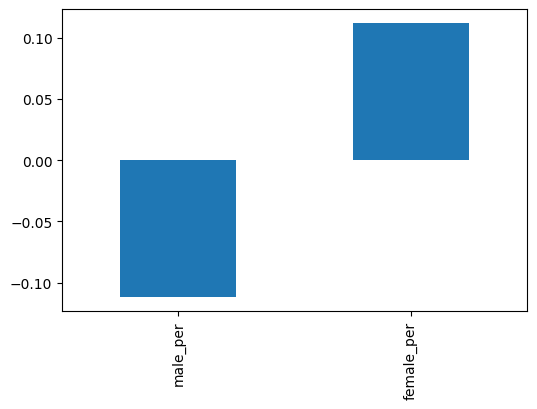

In [55]:
# Creating gender mask
gender_fields = ["male_per", "female_per"]

# Looking at gender differences on SAT scores with a bar plot

combined.corr()["sat_score"][gender_fields].plot.bar()

## Observations
- It looks like there is a small negative correlation between males and SAT score. This would potentially indicate that males perform worse on the SAT.
- There is also a small positive correlation for females which might mean that they perform better than males on the SAT. 
- I should have a further look by exploring the relationship between the variables with a scatterplot.

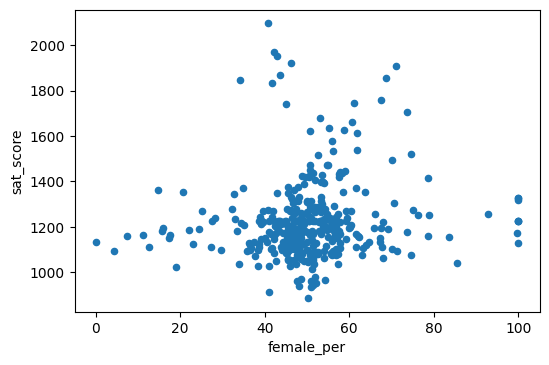

In [57]:
combined.plot.scatter(x = "female_per", y = "sat_score")

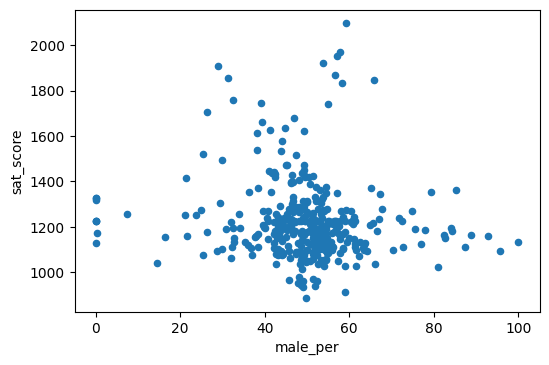

In [58]:
combined.plot.scatter(x = "male_per", y = "sat_score")

## Observations 
- Based on these plots there doesn't look to be any real relationship between `sat_score` and `female_per` or `male_per`. 
- One interesting note:
    * There is a cluster of schools with a high number of girls 60-80% and high SAT scores. We should explore this further. 

In [60]:
# High number of females variable
high_per_fem = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]
print(high_per_fem)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## Observations
- After googling the schools listed above, the schools look like liberal art schools that are highly selective.

Our final form of analysis is going to look at schools and the proportion of students who took AP exams. AP exams stand for advanced placement which indicates a level of excellence for a student. It would make sense to explore the relationship schools who have high AP totals to their SAT scores. 

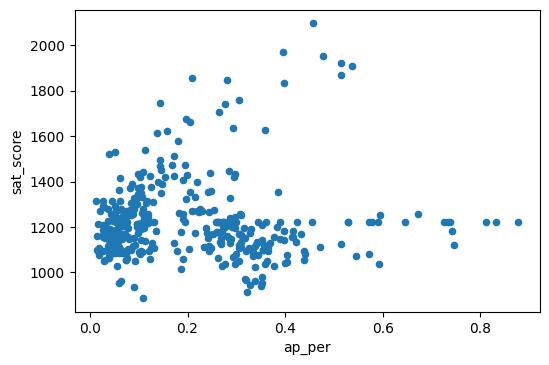

In [62]:
# Calculating the percentage of students at each schools that took the AP exam
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

# Plot the relationship between AP scores and SAT scores

combined.plot.scatter(x= "ap_per", y = "sat_score")

## Observations
- It looks like there is a slight relationship between the number of students who took the AP exam and their SAT test score. Schools with a lower number of students who took AP exams had lower overall SAT test scores which can be seen by the cluster on the left of the plot. 

# Conclusions
- Students and their feelings of safety at schools had a strong correlation with their performance on the SAT. This makes sense as we all want to study in a safe environment. 
- I found a strong negative correlation between hispanic students and their scores on the SAT. This means that students who are hispanic generally score lower on the SAT. However, this probably isn't because they are hispanic, but are at schools in boroughs who have a lack of funding or the schools are designated for recently immigrated students with lower levels of English fluency.
- Schools that had higher white and asian populations tended to be schools in technology and science that had selection exams (a form of standardized test) which would indicate their students ability to perform well on these tests. 
- We explored gender relationships and found weak correlations between gender and SAT performance, however these correlations when visualized weren't significant. 
- Finally we looked at schools and the number of students who take an AP course and how they perform overall on the SAT. We found that schools who had a lower number of students taking AP courses performed worse overall on the SAT. 